In [30]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds
import time
#tfds.list_builders()

In [2]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [4]:
def parse_aug_fn(dataset):
    def zoom(x, sh = 224, sw = 224):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    y = tf.one_hot(dataset['label'], 10)
    y = y
    
    return x, y

In [5]:
#模型儲存目錄
model_dir = 'cifar10/models'
if os.path.isdir(model_dir):
    print("已存在路徑「{}」".format(model_dir))
else:
    print("已建立路徑「{}」".format(model_dir))
    os.makedirs(model_dir)

已存在路徑「cifar10/models」


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 16
train_num = int(info.splits['train'].num_examples / 10) * 9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data = train_data.batch(batch_size)
  
valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.batch(batch_size)
 
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.batch(batch_size)

In [7]:
input_shape = (224, 224)

base_model = keras.applications.MobileNetV2(include_top = False, weights="imagenet", pooling='avg', input_shape=input_shape+(3,))

# model=keras.Sequential([
#     base_model,
#     layers.Dense(1024,activation='relu', kernel_regularizer = 'l2'),
#     layers.Dense(10,activation='softmax')
# ])

In [10]:
model = keras.models.load_model(model_dir + "/Best-model-MobileNetV2-L2.h5")

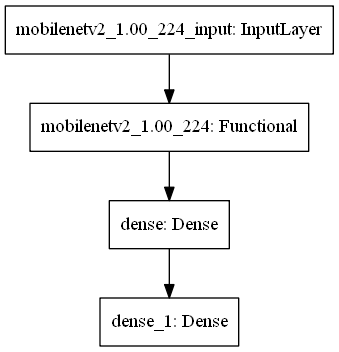

In [8]:
plot_model(model)

In [9]:
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_apply = tfmot.quantization.keras.quantize_apply

In [11]:
weights = model.get_weights()
base_weights = base_model.get_weights()
base_model.set_weights(weights[:len(base_weights)])
last_weights = weights[len(base_weights):]
q_aware_base_model = quantize_model(base_model)

In [13]:
q_model=keras.Sequential([
    q_aware_base_model,
    layers.Dense(1024,activation='relu', kernel_regularizer = 'l2'),
    layers.Dense(10,activation='softmax')
])

In [15]:
weights = q_model.get_weights()
weights[-4:] = last_weights
q_model.set_weights(weights)

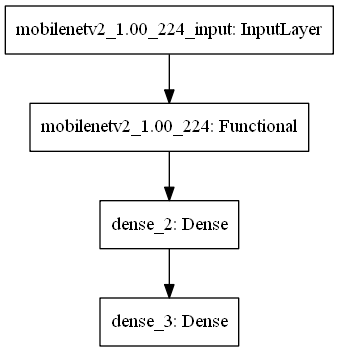

In [14]:
plot_model(q_model,to_file='q_model.png')

In [16]:
q_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2278142   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 3,600,136
Trainable params: 3,545,866
Non-trainable params: 54,270
_________________________________________________________________


In [17]:
#優化器、損失函數，指標函數
q_model.compile(keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])

In [18]:
#回調函數
log_dir = os.path.join('cifar10','Q-MobileNetV2-L2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq ='epoch')
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + "/Q-model-MobileNetV2-L2.h5", monitor='val_categorical_accuracy', mode='max')
# model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=300, mode='max')

In [19]:
history = q_model.fit(train_data, epochs=10, initial_epoch=0, validation_data = valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/10
   1/2813 [..............................] - ETA: 0s - loss: 0.8581 - categorical_accuracy: 0.8750WARNING:tensorflow:From C:\Users\user\myenv\tf2_3_gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2813/2813 [==============================] - 1000s 356ms/step - loss: 0.0277 - categorical_accuracy: 0.9943 - val_loss: 0.3807 - val_categorical_accuracy: 0.9216
Epoch 2/10
2813/2813 [==============================] - 989s 352ms/step - loss: 0.0267 - categorical_accuracy: 0.9948 - val_loss: 0.3193 - val_categorical_accuracy: 0.9268
Epoch 3/10
2813/2813 [==============================] - 992s 353ms/step - loss: 0.0251 - categorical_accuracy: 0.9952 - val_loss: 0.4003 - val_categorical_accuracy: 0.9158
Epoch 4/10
2813/2813 [==============================] - 991s 352ms/step - loss: 0.0282 - categorical_accuracy: 0.9947 - val_loss: 0.3787 - val_categorical_accuracy: 0.9172
Epoch 5/10
2813/2813 [==============================] - 993s 353ms/step - loss: 0.0269 - categorical_accuracy: 0.9946 - val_loss: 0.4648 - val_categorical_accuracy: 0.9058
Epoch 6/10
2813/2813 [==============================] - 990s 352ms/step - loss: 0.0252 - categorical_accuracy: 0.9952 - val_loss: 0.4535 - val_categor

In [ ]:
#讀取檔案
with quantize_scope():
    model_dir = 'cifar10/models'
    q_model = tf.keras.models.load_model(model_dir + "/Q-model-MobileNetV2-L2.h5")

In [20]:
# 訓練後的評估
print("train_data:")
model.evaluate(train_data)
print("valid_data:")
model.evaluate(valid_data)
print("test_data:")
model.evaluate(test_data)

train_data:
2813/2813 [==============================] - 62s 22ms/step - loss: 0.0231 - categorical_accuracy: 0.9954
valid_data:
313/313 [==============================] - 7s 22ms/step - loss: 0.3626 - categorical_accuracy: 0.9240
test_data:
625/625 [==============================] - 14s 22ms/step - loss: 0.3846 - categorical_accuracy: 0.9185


[0.38457027077674866, 0.9185000061988831]

In [23]:
# 訓練後的評估
print("train_data:")
q_model.evaluate(train_data)
print("valid_data:")
q_model.evaluate(valid_data)
print("test_data:")
q_model.evaluate(test_data)

train_data:
2813/2813 [==============================] - 1133s 403ms/step - loss: 0.0249 - categorical_accuracy: 0.9952
valid_data:
313/313 [==============================] - 125s 400ms/step - loss: 0.3554 - categorical_accuracy: 0.9214
test_data:
625/625 [==============================] - 251s 402ms/step - loss: 0.3958 - categorical_accuracy: 0.9118


[0.3958280682563782, 0.9118000268936157]

# 待解決部分1

In [7]:
# input_shape = (224, 224)

# base_model = keras.applications.MobileNetV2(include_top = False, weights="imagenet", pooling='avg', input_shape=input_shape+(3,))

# model=keras.Sequential([
#     base_model,
#     layers.Dense(1024,activation='relu', kernel_regularizer = 'l2'),
#     layers.Dense(10,activation='softmax')
# ])

In [22]:
q_model = quantize_model(model)

ValueError: Quantizing a tf.keras Model inside another tf.keras Model is not supported.